### ▶2024/06/04 新規データを機械学習モデルに入力する準備をする

##### ▶ライブラリ

In [1]:
import pandas as pd
import numpy as np
import pickle
from pipeline_functions import PipelineFunctions
from view_functions import ViewFunctions
vf = ViewFunctions()
pf = PipelineFunctions()

##### ▶データの生成

In [3]:
drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0).query('is_asai == 1')
# 永松さん紙箱1回目
nw_info  = drawing_info.query('name == "永松若葉"').query('motif == "紙箱"').query('times == 1')

In [12]:
### 変えないパラメータ ###
sample_type, sample_size, feature_name = 'smaller_cossim', 16, 'startend_seg_cossim'

drawing_id = nw_info['drawing_id'].iloc[0]
tsv_path = f'../data/all_tsv/id_{drawing_id}.tsv'
rotate_type = nw_info['rotate_type'].iloc[0]

nw_data = pf.get_pipelined_data(tsv_path, rotate_type, sample_type, sample_size)
nw_X = pf.get_only_pipelined_feature(nw_data, feature_name)
norm_nw_X = pf.scale_minmax(nw_X, sample_type, sample_size, feature_name)

------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
------------ exception segment -------------
----------

In [14]:
norm_nw_X.min()

norm_feature_0    -2.966282e-06
norm_feature_1    -5.660555e-06
norm_feature_2     2.491785e-06
norm_feature_3    -4.078420e-07
norm_feature_4     8.980543e-06
norm_feature_5    -2.613433e-06
norm_feature_6    -2.917054e-05
norm_feature_7    -3.513681e-07
norm_feature_8    -1.796834e-05
norm_feature_9     1.729924e-07
norm_feature_10    6.232374e-07
norm_feature_11   -3.994838e-06
norm_feature_12   -5.942705e-05
norm_feature_13   -7.322550e-06
norm_feature_14    3.751562e-07
dtype: float64

##### ▶データの確認⇒OK

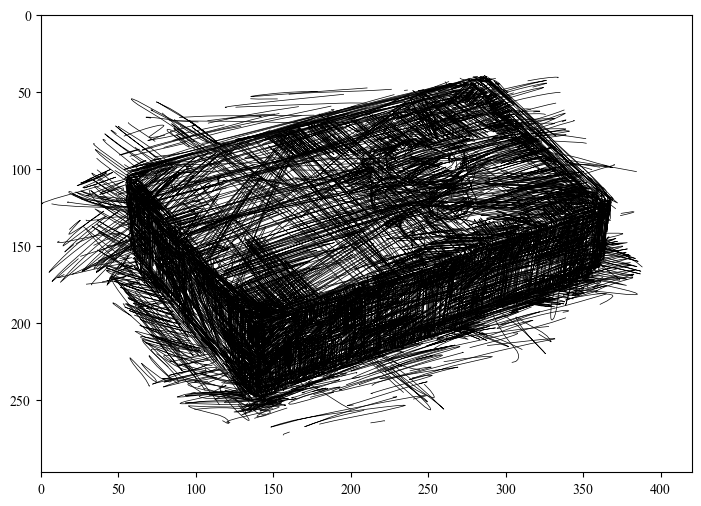

In [7]:
vf.draw_all_stroke(nw_data['rotated_x'], nw_data['rotated_y'], rotate_type)

##### ▶SVMの最適モデルをpickleオブジェクトとして保存

##### ▶▶最適モデルの作成

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### 変えないパラメータ ###
TRAIN_TEST_SPLIT_SEED = 1
KFOLD_SHUFFLE_SEED = 1
KFOLD_SHUFFLE_LABEL = 'saito_label'
Y_COL = 'is_good_saito'
K = 5
#######################
### 変えるパラメータ ###
ptcnt_type, ptcnt, input_col = 1, 16, 'startend_seg_cossim'
kernel, c, gamma, degree = 'rbf', 5, 0.1, 1
#######################

# 元データ
data = pd.read_csv(f'../temp/eachpt_feature/{ptcnt_type}_{ptcnt}_{input_col}.csv', delimiter=',', index_col=0)
X = data.copy()
y = data[Y_COL]
# 学習データとテストデータを725:310に分割する
train_valid, test, y_train_valid, y_test = train_test_split(X, y, train_size=725, shuffle=True, stratify=y, random_state=TRAIN_TEST_SPLIT_SEED)

### 説明変数と目的変数に分ける ###
X_col = [col for col in train_valid if 'feature_' in col]
y_col = 'is_good_saito'
train_valid_X = train_valid.copy()[X_col]
train_valid_y = train_valid.copy()[y_col]
test_X = test.copy()[X_col]
test_y = test.copy()[y_col]

### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
scaler = MinMaxScaler()
for col in train_valid_X:
    train_minmax = scaler.fit(train_valid_X[[col]])
    train_valid_X[f'norm_{col}'] = scaler.transform(train_valid_X[[col]])
    test_X[f'norm_{col}'] = scaler.transform(test_X[[col]])
    del train_valid_X[col]
    del test_X[col]

### モデルへの入力形式に変換する ###
np_train_valid_X = train_valid_X.to_numpy()
np_train_valid_y = train_valid_y.to_numpy()
np_test_X = test_X.to_numpy()
np_test_y = test_y.to_numpy()

### モデルを生成する ###
model = SVC(kernel=kernel, C=c, gamma=gamma, degree=degree)
### モデルを学習させる ###
result = model.fit(np_train_valid_X, np_train_valid_y)
### 検証データで精度を算出する ###
test_pred = model.predict(test_X)
### 各指標の値(testデータに対する) ###
recall = recall_score(np_test_y, test_pred, average=None)[1]
precision = precision_score(np_test_y, test_pred, average=None)[1]
f1 = f1_score(np_test_y, test_pred, average=None)[1]
accuracy = accuracy_score(np_test_y, test_pred)

ValueError: Found array with 0 feature(s) (shape=(725, 0)) while a minimum of 1 is required by SVC.

##### ▶▶最適モデルをpickleファイルとして保存

In [24]:
import pickle
#学習モデルの保存
with open('../temp/model_and_scaler/svm_best_score/model.pkl', mode='wb') as f:
    pickle.dump(model, f, protocol=2)

In [26]:
# モデルの読み込み
with open('../temp/model_and_scaler/svm_best_score/model.pkl', mode='rb') as f:
    best_score_model = pickle.load(f)

# ### 検証データで精度を算出する ###
# predict = best_score_model.predict(test_X)
# ### 各指標の値(testデータに対する) ###
# recall = recall_score(np_test_y, test_pred, average=None)[1]
# precision = precision_score(np_test_y, test_pred, average=None)[1]
# f1 = f1_score(np_test_y, test_pred, average=None)[1]
# accuracy = accuracy_score(np_test_y, test_pred)

##### ▶minmaxスケーラーをpickleファイルとして保存

In [30]:
with open('../temp/model_and_scaler/svm_best_score/minmax_scaler.pkl', mode='wb') as f:
    pickle.dump(train_minmax, f, protocol=2)

In [38]:
train_data = pd.read_pickle('../data/shape_groundtruth_data.pkl').reset_index()

##### ▶永松さん紙箱1回目を推論する

In [2]:
# モデルの読み込み
with open('../temp/model_and_scaler/svm_best_score/model.pkl', mode='rb') as f:
    best_score_model = pickle.load(f)

np_nw_X = norm_nw_X.to_numpy()
nw_predict = best_score_model.predict(np_nw_X)

NameError: name 'norm_nw_X' is not defined

In [19]:
len(nw_predict)

1328

In [20]:
len(nw_data)

1328

In [21]:
df_precict = pd.DataFrame({'predict': nw_predict})

pd.concat([nw_data, nw_predict], axis=1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid